### Import dos Pacotes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import numpy as np

### Import dos Dados

In [2]:
df = pd.read_csv('Usuarios-TempoMedioQuantidade.csv', sep=';', engine='python')

In [3]:
# formato dos dados
df.shape

(602, 6)

In [4]:
# primeiras 5 linhas do df
df.head()

,NomeUsuario,Login,Email,NomeEquipe,Quantidade,TempoMedio
0,dadostab1,dadostab1,dadostab1@dadospesquisa.com.br,Equipe Dados Pesquisa,1498,0
1,axistab2,axistab2,axistab2@axiscriativa.com.br,Equipe Axis Criativa,461,75
2,axistab1,axistab1,axistab1@axiscriativa.com.br,Equipe Axis Criativa,445,7
3,planocdetab1,planocdetab1,planocdetab1@planocde.com.br,Equipe PlanoCDE,423,140
4,Usuario11,usuario11,usuario11@marketnnova.com,Equipe Marketnnova,351,22


In [5]:
# verificando se há dados faltantes
df.isna().sum()

NomeUsuario    0
Login          0
Email          0
NomeEquipe     0
Quantidade     0
TempoMedio     0
dtype: int64

- Não há dados faltantes

### Normalizando os Dados

In [6]:
# instanciando o objeto
scaler = MinMaxScaler()

In [7]:
# aplicando a transformação e salvando em outro df
df_norm = scaler.fit_transform(df[['Quantidade','TempoMedio']])

# voltando para um dataframe
df_norm = pd.DataFrame(df_norm, columns=['Quantidade', 'TempoMedio'])

# exibindo as 5 primeiras linhas
df_norm.head()

,Quantidade,TempoMedio
0,1.000000,0.000000
1,0.307281,0.057559
2,0.296593,0.005372
3,0.281897,0.107444
4,0.233801,0.016884


### Visualizando os Dados

Text(0.5, 1.0, 'Qtd. vs. Tempo Médio')

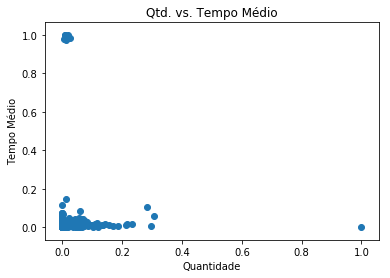

In [8]:
plt.scatter(df_norm['Quantidade'], df_norm['TempoMedio'])
plt.xlabel('Quantidade')
plt.ylabel('Tempo Médio')
plt.title('Qtd. vs. Tempo Médio')

A análise visual sugere 2 ou 3 clusters, com um possível outlier no ponto (1,0). Vamos entender mais profundamente com a clusterização via **KMeans** e **DBScan**

### Clusterizando com KMeans

In [9]:
# aux var para entender qtd ideal de clusters
scores = []
inertias =[]

# for para testar qtd ideal de clusters
for i in tqdm(range(2,15)):
    kmeans = KMeans(n_clusters=i).fit(df_norm)
    
    # anexa o somatório dos erros quadráticos das instâncias de cada cluster
    inertias.append(kmeans.inertia_)
    
    # anexa o valor do silhouette_score
    scores.append(silhouette_score(df_norm.values, kmeans.labels_))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.40it/s]


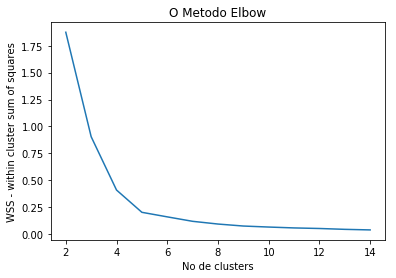

In [10]:
# Visualizando qtd de Clusters pelo Método do Cotovelo

plt.figure(1)
plt.plot(range(2, 15), inertias)
plt.title('O Metodo Elbow')
plt.xlabel('No de clusters')
plt.ylabel('WSS - within cluster sum of squares')
plt.show()

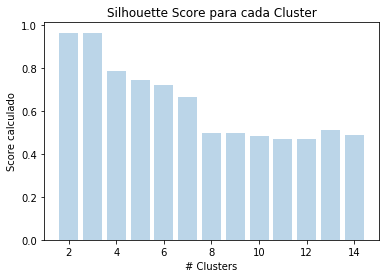

In [11]:
# Visualizando qtd de Clusters pelo K-Means

plt.figure(2)
plt.bar(range(2,15), scores, align='center', alpha = 0.3)
plt.title('Silhouette Score para cada Cluster')
plt.xlabel('# Clusters')
plt.ylabel('Score calculado')
plt.show()

Pelo método do cotovelo, não é fácil entender a quantidade ideal de clusters. Pelo método do silhouette Score, aparentemente podemos optar por dois ou três *clusters*. Vamos analisar primeiramente o resultado com 3 *clusters*

Silhouette Score do Agrupamento pelo KMeans: 0.9635408613727433


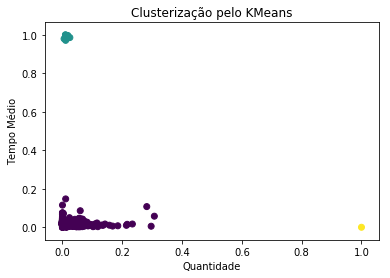

In [12]:
kmeans = KMeans(n_clusters=3).fit(df_norm)
plt.scatter(df_norm['Quantidade'], df_norm['TempoMedio'], c=kmeans.labels_)
plt.xlabel('Quantidade')
plt.ylabel('Tempo Médio')
plt.title('Clusterização pelo KMeans')

print('Silhouette Score do Agrupamento pelo KMeans: {}'.format(silhouette_score(df_norm, kmeans.labels_)))

Aqui vemos que foi criado um cluster apenas para um único ponto, que aparenta ser um *outlier*. Se fizermos a clusterização com 2 *clusters*:

Silhouette Score do Agrupamento pelo KMeans: 0.9638828277346381


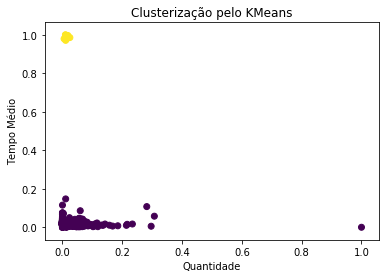

In [13]:
kmeans = KMeans(n_clusters=2).fit(df_norm)
plt.scatter(df_norm['Quantidade'], df_norm['TempoMedio'], c=kmeans.labels_)
plt.xlabel('Quantidade')
plt.ylabel('Tempo Médio')
plt.title('Clusterização pelo KMeans')

print('Silhouette Score do Agrupamento pelo KMeans: {}'.format(silhouette_score(df_norm, kmeans.labels_)))

Aqui vemos que foram criados 2 *clusters*, mas o ponto *outlier* foi agrupado junto com os demais. Esta abordagem também não parece ser a ideal. Vamos analisar o agrupamento com o DBScan.

### Clusterizando com DBScan

In [14]:
#Selecionando o melhor valor para o eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_norm)
distances, indices = nbrs.kneighbors(df_norm)

Matriz das distâncias: 
[[0.         0.03934512]
 [0.         0.05327048]
 [0.         0.05327048]
 [0.         0.0559719 ]
 [0.         0.69510603]]


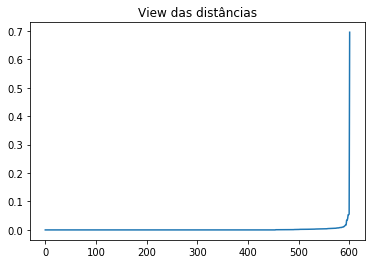

In [15]:
distances = np.sort(distances, axis=0)

print('Matriz das distâncias: ')
print(distances[-5:])


distances = distances[:,1]
plt.plot(distances)
plt.title('View das distâncias')
plt.show()

A análise acima pelo gráfico não é simples, portanto optamos por imprimir também os dados da matriz. Com isto, optamos por um espilon de 0.1.

In [16]:
# aux var para entender a qtd mínima de amostras
scores = []

# for para testar qtd ideal de amostras
for i in tqdm(range(2,11)):
    db = DBSCAN(eps=0.1, min_samples=i).fit(df_norm)
    
    # anexa o valor do silhouette_score
    scores.append(silhouette_score(df_norm, db.labels_))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.45it/s]


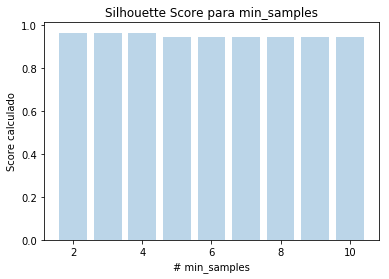

In [17]:
# Visualizando o Silhouette Score pela quantidade de amostras

plt.figure(3)
plt.bar(range(2,11), scores, align='center', alpha = 0.3)
plt.title('Silhouette Score para min_samples')
plt.xlabel('# min_samples')
plt.ylabel('Score calculado')
plt.show()

Temos aqui que a quantidade de pontos para min_samples pode ser qualquer valor entre 2 e 4 sem prejuízo. Vamos escolher 3 por conveniência.

Silhouette Score do Agrupamento: 0.9635408613727433


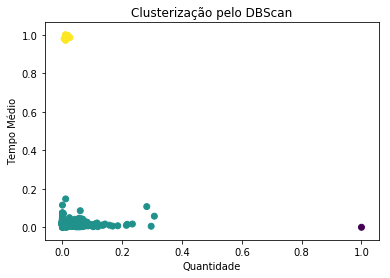

In [18]:
db = DBSCAN(eps=0.1, min_samples=3).fit(df_norm)
plt.scatter(df_norm['Quantidade'], df_norm['TempoMedio'], c=db.labels_)
plt.xlabel('Quantidade')
plt.ylabel('Tempo Médio')
plt.title('Clusterização pelo DBScan')

print('Silhouette Score do Agrupamento: {}'.format(silhouette_score(df_norm, db.labels_)))

## Respostas do Exercício

#### a) O que representam os clusters gerados?

Os clusters representam grupos de características com características similares. No caso em análise, dois fatores foram considerados:
- Quantidade
- Tempo Médio

#### b) Qual a melhor quantidade de clusters?

A melhor quantidade de clusters é **dois**. Este resultado foi obtido pelo método do KMeans e também pelo DBScan

#### c) Qual a melhor técnica (KMeans ou DBScan) a ser utilizada nesta clusterização?

A melhor técnica para este caso é o **DBScan**. O caso analisado tem um *outlier* claro, que não é bem tratado pelo KMeans. O DBScan, por sua característica, conseguiu identificar que tratava-se de um ruído, e portanto isolou o ponto.